## Problem 1
Remember from last week we discussed that skewness and kurtosis functions in statistical
packages are often biased. Is your function biased? Prove or disprove your hypothesis.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, t, ttest_1samp

In [2]:
def test_bias(n_iter, sample_size, func, expected_value, func_name):
    value = np.empty(n_iter)
    for i in range(n_iter):
        value[i] = func(np.random.normal(0, 1, sample_size))
        
    avg = np.mean(value)
    t_stat, p_value = ttest_1samp(value, expected_value)
    
    print(f"Sample size is {sample_size}.")
    print(f"Average {func_name}: {avg:.5f}")
    print(f"t-statistic: {t_stat:.5f}, p-value: {p_value:.5f}")
    
    if p_value < 0.05:
        print(f"Test the {func_name} function for bias: Reject the Null Hypothesis.\n")
    else:
        print(f"Test the {func_name} function for bias: Fail to reject the Null Hypothesis.\n")
    
sample_sizes = [100, 1000, 10000]
n_iter = 1000

for s in sample_sizes:
    # Testing kurtosis for bias
    test_bias(n_iter, s, kurtosis, 0, "Kurtosis")  # expected excess kurtosis is 0 for a normal distribution

    # Testing skewness for bias
    test_bias(n_iter, s, skew, 0, "Skewness")  # expected skewness is 0 for a normal distribution

Sample size is 100.
Average Kurtosis: -0.07721
t-statistic: -5.17159, p-value: 0.00000
Test the Kurtosis function for bias: Reject the Null Hypothesis.

Sample size is 100.
Average Skewness: -0.00995
t-statistic: -1.31134, p-value: 0.19005
Test the Skewness function for bias: Fail to reject the Null Hypothesis.

Sample size is 1000.
Average Kurtosis: 0.00272
t-statistic: 0.55614, p-value: 0.57824
Test the Kurtosis function for bias: Fail to reject the Null Hypothesis.

Sample size is 1000.
Average Skewness: -0.00069
t-statistic: -0.28762, p-value: 0.77370
Test the Skewness function for bias: Fail to reject the Null Hypothesis.

Sample size is 10000.
Average Kurtosis: -0.00389
t-statistic: -2.49480, p-value: 0.01276
Test the Kurtosis function for bias: Reject the Null Hypothesis.

Sample size is 10000.
Average Skewness: 0.00107
t-statistic: 1.42889, p-value: 0.15335
Test the Skewness function for bias: Fail to reject the Null Hypothesis.



## Problem 2
Fit the data in problem2.csv using OLS and calculate the error vector. Look at its distribution.
How well does it fit the assumption of normally distributed errors?

Fit the data using MLE given the assumption of normality. Then fit the MLE using the
assumption of a T distribution of the errors. Which is the best fit?

What are the fitted parameters of each and how do they compare? What does this tell us about
the breaking of the normality assumption in regards to expected values in this case?

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

dat = pd.read_csv("problem2.csv")

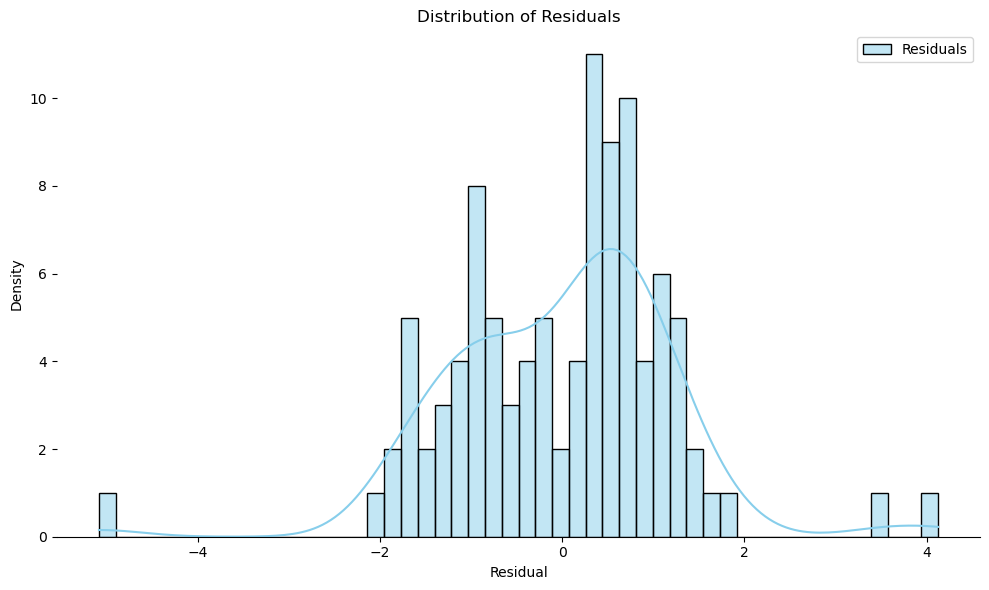

In [7]:
# Fit the OLS model
X = sm.add_constant(dat['x'])
model = sm.OLS(dat['y'], X).fit()

# Calculate the error vector
residuals = model.resid

# Use Seaborn to create a visually appealing histogram of residuals without passing the 'color' argument to the KDE
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color="skyblue", label="Residuals")

# Customize the plot for better visualization
sns.despine(left=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()

plt.show()

In [10]:
# Perform the Shapiro-Wilk test for normality on residuals
shapiro_result = stats.shapiro(residuals)
shapiro_result

ShapiroResult(statistic=0.9383853673934937, pvalue=0.00015388781321235)

In [24]:
# MLE
# Define the negative log-likelihood for the normal distribution
def neg_ll_normal(p):
    mu, sigma = p
    neg_ll = -np.sum(stats.norm.logpdf(dat['y'], loc=mu + dat['x']*sigma, scale=sigma))
    return neg_ll

# Define the negative log-likelihood for the t distribution
def neg_ll_t(p):
    mu, sigma, nu = p  # nu is the degrees of freedom for the t distribution
    neg_ll = -np.sum(stats.t.logpdf(dat['y'], df=nu, loc=mu + dat['x']*sigma, scale=sigma))
    return neg_ll

# Optimize the negative log-likelihood for the normal distribution
initial_guess_normal = [0, 1]
result_normal = minimize(neg_ll_normal, initial_guess_normal)

# Optimize the negative log-likelihood for the t distribution
initial_guess_t = [0, 1, 2]
result_t = minimize(neg_ll_t, initial_guess_t)

print(f"Log-likelihood using MLE given normality: -{result_normal.fun}\n")
print(f"Log-likelihood using MLE given t error distribution: -{result_t.fun}\n")

Log-likelihood using MLE given normality: -170.31051810005266

Log-likelihood using MLE given t error distribution: -159.78500186588983



In [19]:
# Calculate AIC and BIC for the normal distribution model
k_normal = len(initial_guess_normal)
n = len(dat)
aic_normal = 2 * k_normal + 2 * result_normal.fun
bic_normal = k_normal * np.log(n) + 2 * result_normal.fun

# Calculate AIC and BIC for the t distribution model
k_t = len(initial_guess_t)
aic_t = 2 * k_t + 2 * result_t.fun
bic_t = k_t * np.log(n) + 2 * result_t.fun

print(f"MLE given normality: AIC = {aic_normal}, BIC = {bic_normal}\n")
print(f"MLE given t error distribution: AIC = {aic_t}, BIC = {bic_t}\n")

MLE given normality: AIC = 344.6210362001053, BIC = 349.8313765720815

MLE given t error distribution: AIC = 325.57000373177965, BIC = 333.3855142897439



In [25]:
print(f"Estimated parameters using MLE given normality\n")
print(f"Intercept: {result_normal.x}, slope: {result_normal.x}, standard deviation: {result_normal.x}\n")
# print(f"Estimated parameters using MLE given t error distribution\n")
# print(f"Intercept: {result_t.x[0]}, slope: {result_t.x[1]}, standard deviation: {result_t.x[2]}\n")

Estimated parameters using MLE given normality

Intercept: [0.11988707 1.0790671 ], slope: [0.11988707 1.0790671 ], standard deviation: [0.11988707 1.0790671 ]

